In [5]:
import torch
import numpy as np
import random
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
from itertools import product

%matplotlib inline

In [6]:
class Shape:
    def __init__(self):
        pass
    def get_distance(self, x, y):
        raise NotImplementedError("Abbstract class hve not this method!")

In [77]:
class Circle(Shape):
    def __init__(self, x, y, r):
        self.x = x
        self.y = y
        self.r = r
    def get_score(self, x, y):
        d = np.sqrt((x - self.x) ** 2 + (y - self.y) ** 2)
        if d > self.r:
            return 0
        else:
            return 1 - d / self.r
    def get_distance(self, x, y):
        return np.abs(np.sqrt((x - self.x) ** 2 + (y - self.y) ** 2) - self.r)
    def get_vector_ditance(self, x, y, dx, dy):
        x -= self.x
        y -= self.y
        l = np.sqrt(dx ** 2 + dy ** 2)
        dx /= l
        dy /= l
        a = dx ** 2 + dy ** 2
        b = 2 * dx * x + 2 * dy * y
        c = x ** 2 + y ** 2 - self.r ** 2
        d = b ** 2 - 4 * a * c
        if d < 0:
            return np.inf
        else:
            t1 = (-b - np.sqrt(d)) / (2 * a)
            t2 = (-b + np.sqrt(d)) / (2 * a)
            if t2 < t1:
                t2, t1 = t1, t2
            if t2 < 0:
                return np.inf
            else:
                if t1 < 0:
                    return t2
                else:
                    return t1

In [40]:
class Line(Shape):
    def __init__(self, p1, p2):
        x1, y1 = p1
        x2, y2 = p2
        self.a = y1 - y2
        self.b = x2 - x1
        self.c = -(self.a * x1 + self.b * y1)
    def get_distance(self, x, y):
        return abs((self.a * x + self.b * y + self.c) / np.sqrt(self.a ** 2 + self.b ** 2))

In [60]:
class Segment(Shape):
    def __init__(self, p1, p2):
        self.p1 = p1
        self.p2 = p2
    def get_distance(self, x, y):
        pr = (x - self.p1[0]) * (self.p2[0] - self.p1[0]) + (y - self.p1[1]) * (self.p2[1] - self.p1[1])
        if pr > 0 and pr < (self.p2[0] - self.p1[0]) ** 2 + (self.p2[1] - self.p1[1]) ** 2:
            return Line(self.p1, self.p2).get_distance(x, y)
        return min(np.hypot(x - self.p1[0], y - self.p1[1]), np.hypot(x - self.p2[0], y - self.p2[1]))

In [78]:
class Field:
    def __init__(self, r, obst, cover):
        self.r = r
        self.obst = obst
        self.cover = cover
    def get_neurons(self, x, y):
        return [c.get_score(x, y) for c in self.cover]
    def move(self, x, y, dx, dy):
        l = np.sqrt(dx ** 2 + dy ** 2)
        min_dist = min(map(lambda c: c.get_vector_ditance(x, y, dx, dy), self.obst)) - 1e-5
        min_dist = min(min_dist, Circle(0, 0, self.r).get_vector_ditance(x, y, dx, dy))
        if min_dist < l:
            dx *= min_dist / l
            dy *= min_dist / l
        return (x + dx, y + dy)

In [79]:
def array_draw_objects(x0, x1, y0, y1, sz, objs, r, g, b, progress_bar = False):
    d = 5e-3 * (x1 - x0)
    ans = np.zeros((sz, sz, 3), dtype=np.float)
    coords = product(range(sz), range(sz))
    if progress_bar:
        coords = tqdm_notebook(list(coords))
    for i, j in coords:
            x = x0 + i / sz * (x1 - x0)
            y = y0 + j / sz * (y1 - y0)
            for o in objs:
                s = o.get_distance(x, y)
                if s < d:
                    ans[i][j][0] = r
                    ans[i][j][1] = g
                    ans[i][j][2] = b
    return ans

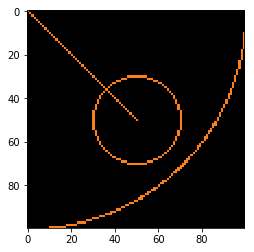

In [80]:
plt.imshow(array_draw_objects(0, 1, 0, 1, 100, [Circle(0, 0, 1), Circle(0.5, 0.5, 0.2), Segment((0, 0), (0.5, 0.5))], 1, 0.5, 0.1))

29


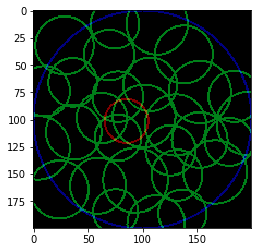

In [83]:
r = 100
cnt = 0
cover = []
while cnt < 100:
    cnt += 1
    rr = random.random() * r
    ang = random.random() * 2 * np.pi
    x = np.cos(ang) * rr
    y = np.sin(ang) * rr
    f = 1
    for c in cover:
        if c.get_score(x, y) > 0:
            f = 0
            break
    if f:
        cnt = 0
        cover.append(Circle(x, y, random.random() * 10 + 20))
print(len(cover))
arr = array_draw_objects(-r, r, -r, r, 200, cover, 0, 0.5, 0.1, progress_bar=True)
arr += array_draw_objects(-r, r, -r, r, 200, [Circle(0, 0, r)], 0, 0, 0.5)
obst = [Circle(random.random() * 40 - 20, random.random() * 40 - 20, 20)]
arr += array_draw_objects(-r, r, -r, r, 200, obst, 0.5, 0, 0)
plt.imshow(arr)

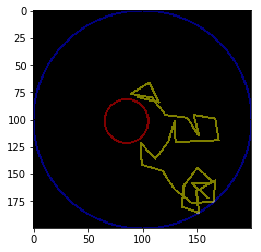

In [85]:
field = Field(r, obst, cover)
arr = array_draw_objects(-r, r, -r, r, 200, [Circle(0, 0, r)], 0, 0, 0.5)
arr += array_draw_objects(-r, r, -r, r, 200, obst, 0.5, 0, 0)
x = y = None
while x == None:
    ang = np.random.random() * 2 * np.pi
    d = np.random.random() * r
    x = d * np.cos(ang)
    y = d * np.sin(ang)
    for o in field.obst:
        if o.get_score(x, y):
            x = y = None
            break
itrs = 30
step = r / 5
segments = []
for i in range(itrs):
    ang = np.random.random() * 2 * np.pi
    dx = step * np.cos(ang)
    dy = step * np.sin(ang)
    nx, ny = field.move(x, y, dx, dy)
    segments.append(Segment((x, y), (nx, ny)))
    x, y = nx, ny
arr += array_draw_objects(-r, r, -r, r, 200, segments, 0.5, 0.5, 0, progress_bar=True)
plt.imshow(arr)

In [92]:
def add_random_neurons(positions, place_neurons, neurons_count):
    ans = np.random.rand(neurons_count)
    for i, x in enumerate(positions):
        ans[x] = place_neurons[i]
    return ans
def make_log(field, iters, neurons_count):
    if neurons_count < len(field.cover):
        neurons_count = len(field.cover)
    positions = random.sample(list(range(neurons_count)), len(field.cover))
    x = y = None
    while x == None:
        ang = np.random.random() * 2 * np.pi
        d = np.random.random() * field.r
        x = d * np.cos(ang)
        y = d * np.sin(ang)
        for o in field.obst:
            if o.get_score(x, y):
                x = y = None
                break
    step = field.r / 5
    coords = [(x, y)]
    log = [add_random_neurons(positions, field.get_neurons(x, y), neurons_count)]
    for i in range(itrs):
        ang = np.random.random() * 2 * np.pi
        dx = step * np.cos(ang)
        dy = step * np.sin(ang)
        x, y = field.move(x, y, dx, dy)
        coords.append((x, y))
        log.append(add_random_neurons(positions, field.get_neurons(x, y), neurons_count))
    return log, coords, positions 

In [93]:
l, c, p = make_log(field, 30, 100)

In [94]:
print(l, c, p)

[array([0.01443465, 0.        , 0.29259175, 0.        , 0.61244007,
       0.87650435, 0.0216409 , 0.48668622, 0.5877975 , 0.89812418,
       0.74996893, 0.18386182, 0.86999106, 0.32254119, 0.68782981,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.93546888, 0.        , 0.98175503, 0.        , 0.57559038,
       0.96798566, 0.45451362, 0.68784182, 0.        , 0.5866226 ,
       0.        , 0.51482193, 0.        , 0.89227557, 0.98974766,
       0.72761778, 0.55197618, 0.70287057, 0.        , 0.8068619 ,
       0.41124587, 0.91512602, 0.98638508, 0.5401904 , 0.88665292,
       0.        , 0.        , 0.6776833 , 0.28209531, 0.55613872,
       0.8613566 , 0.6581945 , 0.51592756, 0.        , 0.68498657,
       0.51538117, 0.39136069, 0.        , 0.5771711 , 0.97317617,
       0.90284321, 0.16287784, 0.07050265, 0.        , 0.        ,
       0.        , 0.        , 0.60976871, 0.40165668, 0.        ,
       0.59638139, 0.76632513, 0.91458483, 0.85409328, 0.0535